# Advances in Machine Learning with Big Data

### Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

## 3. Overfit and regularization

## Contents:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. **Overfit and regularization**

1. Regularization through predictor/feature selection (Lasso etc.)

1. Resampling methods, and model selection

1. Classification

1. Decision trees, bagging, and random forests

1. Make a start on neural networks

1. Causal inference

1. Text classification (&#169; Tensorflow Authors)

1. Word2Vec (&#169; Tensorflow Authors)

1. Convolutional neural nets and image classification (Lucas Kruitwagen)

1. Transfer learning (Lucas Kruitwagen)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np  
import pandas as pd  

In [3]:
#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold

In [4]:
import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

In [5]:
import itertools      # today, we'll use this

### We return to our

### > dataset

### > prediction problem

### > & linear model

**Q.: given the time, date, and complexity of an invoice, what's its expected spend per item shipped?**

In [6]:
df = uci_files.standard_uci_data_access()

2022-05-03 09:35:07,119 INFO:Loading C:\Users\jerem\Documents\work\SBS\MFE\AMLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2022-05-03 09:35:09,017 INFO:Loaded C:\Users\jerem\Documents\work\SBS\MFE\AMLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [7]:
invalids = stock_codes.invalid_series(df)

In [8]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

In [9]:
#  We build some additional columns in our dataframe to take logs etc.:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

In [10]:
predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

In [11]:
# set out `y` and `X` variables:
y = invoices.log_item_spend
X = invoices[predictors] 

# we'll do 25-fold studies this time [for rhetorical purposes!]:
n_folds = 25

In [12]:
model = linear_model.LinearRegression()

The linear model fits OK with 50-fold testing

[Link to `train_n_test`](https://github.com/jeremy-large/ox-sbs-ml-bd/blob/master/lib/sbs_sklearn.py#L21)

2022-05-03 09:35:14,873 INFO:In study 1/25, train on 19753 randomly selected points; then test on the other 824: first few test points = [13 17 32 35 50] 


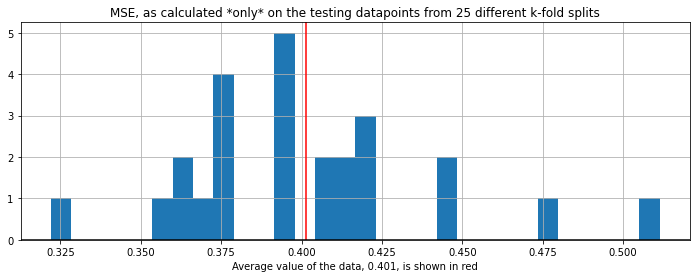

In [13]:
scores = sbs_sklearn.train_n_test(X, y, n_folds, concise=False)
sbs_sklearn.plot_kfold_scores(scores)

OK, now lets stress-test the linear model:

2022-05-03 09:35:15,211 INFO:In study 1/25, train on 824 randomly selected points; then test on the other 19753: first few test points = [0 1 2 3 4] 


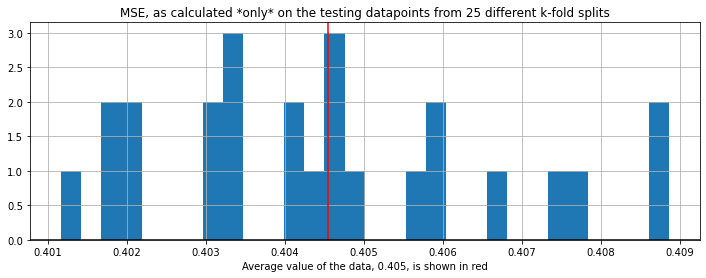

In [14]:
scores = sbs_sklearn.train_n_test(X, y, n_folds, train_on_minority=True, concise=False)   #<< invoke this new option
sbs_sklearn.plot_kfold_scores(scores)

#### Comments:

* our linear model can be fit on a rather small proportion of our dataset

     * not perfectly

* I would say that in part, this is because it is fairly simple and concise

* but this simplicity is tantalising: 

     * could we replace the model with a more complicated one, to get a better MSE?
     

* Extensions to Linear model:

* *Introduction to Statistical Learning* Chapter 3.3.2

### Polynomial Regression:

**Recall our linear setup**: we have an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$ where we are interested in moments of the R.V. $y_i$, conditional on the multivariate R.V.  $x_i$ (of length, say, $p$). 

We *postulate* a linear relationship of the following form:

\begin{equation}
y_i = x_i ' \beta + \epsilon_i,
\end{equation}

where $\beta$ is a vector of parameters of length $p$, and the i.i.d. sequence of random variables $\{\epsilon_i\}$ is independent of the regressors $\{x_i\}$

**Perhaps** we are missing interactions or non-linearities. So, lets try augmenting the vector $x_i$ by adding to it all possible cross-products, 

\begin{equation}
\{x_{i, p} x_{i, q} \ : \ p, q \in \mathbb N \text{ such that } p \leq q\},
\end{equation} 

... and we can go up to third, and higher orders, so $x_{i, p} x_{i, q} x_{i, r}$, or ... etc.

In [15]:
def build_polynomial_dataframe(data, order):
    """
    @param data: a DataFrame() of features (or regressors)
    @param order: a positive integer - the highest order of polynomial terms to be generated
    @return: a DataFrame() containing data, as well as polynomial terms of that data, up to order 
    This dataframe is standardized by its empirical mean and std
    This function really just *wraps* itertools.combinations_with_replacement()
    """
    poly_data = data.copy()
    for o in range(1, order + 1):
        for tpl in itertools.combinations_with_replacement(data.columns, o):
            name = "_x_".join(tpl)
            poly_data[name] = data[list(tpl)].prod(axis=1)
    return ((poly_data - poly_data.mean()) / poly_data.std())

What is this `itertools.combinations_with_replacement()`?

 - Always the same answer:
 
 - https://duckduckgo.com/?q=itertools+combinations+with+replacement&ia=web
 
Later, we'll see scikit-learn's package to pre-process $X$ in this and other ways, [scikit-learn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)

Now we'll create polynomials of, say, orders up to 4:

In [16]:
polynomial_X = build_polynomial_dataframe(invoices[predictors], 4)
polynomial_X.shape

(20577, 69)

In [17]:
polynomial_X.head(1).T

Invoice,489434
log_n_codes,-0.369473
hour,-2.379464
month,-3.344047
words_per_item,0.635705
log_n_codes_x_log_n_codes,-0.603204
...,...
month_x_month_x_month_x_month,0.291475
month_x_month_x_month_x_words_per_item,0.630093
month_x_month_x_words_per_item_x_words_per_item,0.479931
month_x_words_per_item_x_words_per_item_x_words_per_item,0.308057


In [18]:
y.head(1)

Invoice
489434    1.113165
Name: log_item_spend, dtype: float64

2022-05-03 09:35:15,847 INFO:Study 1/25: 19753 train rows;  824 test rows


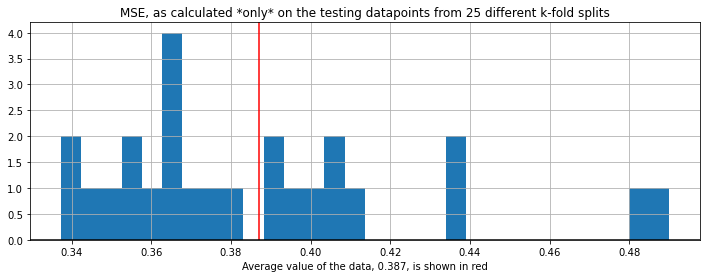

In [19]:
scores = sbs_sklearn.train_n_test(polynomial_X, y, n_folds, concise=True)   
# NB the default value for concise=True, so I'll drop mention of it after now
sbs_sklearn.plot_kfold_scores(scores)

This seems to be helping - MSE is best yet, well below 0.4

#### However, the added flexibility comes with a sting ...

### The 'jaggedness' of a small dataset is instilled into the fit, causing trouble in test data:

2022-05-03 09:35:16,693 INFO:Study 1/25: 824 train rows;  19753 test rows


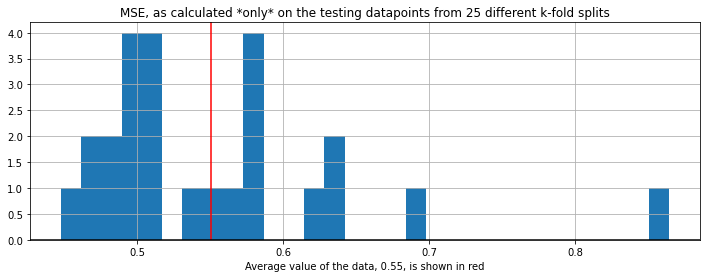

In [20]:
scores = sbs_sklearn.train_n_test(polynomial_X, y, n_folds, train_on_minority=True)  # << we're making this train on a minority ...
sbs_sklearn.plot_kfold_scores(scores)

#### Particularly problematic when there are many regressors, i.e. when $x_i$ has a high dimension

*Introduction to Statistical Learning* 6.4

**Exercise**: 

* Explain the concept of 'mean absolute error'.

* Create a duplicate of this notebook with a new name (e.g. copy-paste)

* Opening the duplicate notebook with jupyter:
    1. run all boxes until this point
    2. next adjust the boxes above to replace MSE with MAE, and 
    3. finally, rerun and observe the results
    
* Do your findings affirm or contradict the message of these slides so far?

## Overfitting

The model had better, at least, perform on **test**, or **hold-out** data

Or how could we trust it for future use?

* tight fit on training data but failure on test data
* -> **overfitting**, or - to put it another way -
* poor **[bias/variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#/media/File:Test_function_and_noisy_data.png)** (*Introduction to Statistical Learning* 2.2.2)

We fit our model to the specific nature ('jaggedness') of the data which we happen to have at hand

Our modelling **fails to generalise** to new cases. It just 'encodes' the training data at hand.

There exists a collection of remedies, falling under the term **Regularization** [-> Wikipedia](https://en.wikipedia.org/wiki/Regularization_(mathematics) )

## Regularization

*Introduction to Statistical Learning* 6.2

**Background** : when we *fit* a model, we optimize an objective
* recall, MLEs, $\hat\beta$, of $\beta$
    * ('hat' notation of Econometrics)

In the case of linear regression, we adjust the vector $\hat\beta$ until we have optimized the objective:
\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\hat\beta\right)^2
\end{equation}
Perhaps we can solve this analytically

* but perhaps (recall ARCH(1) model) we *have* to use numerical minimization

Regularization is the practice of 
  * adjusting this objective, or,
  * constraining our ability to minimize numerically, or
  
  * ...
     *  -> in the direction of *simplicity*

#### The central proposal in regularization, is to adjust this optimization to **penalize complexity**:

for example, actually adjust the vector $\hat\beta$ until we have minimized:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\hat\beta\right)^2  +  \hat\beta'W\hat\beta
\end{equation}

If $W >> 0 $, we're going to *tilt* our optimum in the direction of simplicity

* because unimportant elements of $\hat\beta$ are going to be driven towards zero 

-> So, fewer parameters are in play

<-> [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor)

**Exercise** :
1. is the weights $W$ a matrix, a vector, or a scalar? 

1. is it constant or random?

1. consider what $W >> 0$ could/should mean mathematically. 

1. should $W$ generally just be diagonal?

1. can you think of any alternatives to this quadratic function of $\beta$ (i.e. to $\beta'W\beta$)?

#### Ridge regression:

[(web search)](https://duckduckgo.com/?t=ffsb&q=ridge+regression&ia=web)

Instead of OLS objective, we adjust the vector $\hat\beta$ to minimize:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\hat\beta\right)^2  +  \frac{1}{2}\alpha\hat\beta'\hat\beta
\end{equation}

We have *parameters*, here $\beta$, but we also have *tuning parameters*, here $\alpha$

Because it is a quadratic, we say that the penalty, $\frac{1}{2}\alpha\hat\beta'\hat\beta$, is **L2**

#### Lets have in mind five alternatives to the **L2** penalty above:

A ([AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion#Definition)):


\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\hat\beta\right)^2 . \exp{\left(\frac{2(p + 1)}N\right)}
\end{equation}

So, this multiplies insteading of adding, and complexity is assessed by counting parameters (as $\beta$ is of length $p$).

* [Alternative to AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion#Comparison_with_BIC), called BIC, replaces the $2(p+1)$ with $ln(N)(p+1)$.

B (Lasso):


\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\hat\beta\right)^2  +  \alpha\sum_{j=0}^p|\hat\beta_j|
\end{equation}

Original formulation (makes no difference): minimize the usual objective, but subject to a constraint: 

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\hat\beta\right)^2  \text{: subject to } \sum_{j=0}^p|\hat\beta_j| \leq k
\end{equation}

(where $\alpha$ and $k$ are [related] tuning parameters). This is an **L1** penalty.

[Tibshirani (1996)](https://www.jstor.org/stable/2346178) - we should understand Figure 2

(also note Fig 5 - we will be making something similar later)

C (Elastic Net):


\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\hat\beta\right)^2  + \gamma \alpha \sum_{j=0}^p|\hat\beta_j| + (1-\gamma)\alpha \frac 12\hat\beta'\hat\beta
\end{equation}

Nothing especially new - just a mixture of $\gamma$ times Lasso plus $(1-\gamma)$ times Ridge Regression

**Discussion** : which are the *parameters*, which are the *tuning parameters*?

D (Early stopping):

Adjust the vector $\beta$ to minimize:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\beta\right)^2  +  \text{increasing penalty for computational time/effort during optimization}
\end{equation}

(notation: often in discussing ML we'll be dropping the hat from things like $\hat\beta$) 

E (A simple 'Dropout'):

Adjust the vector $\beta$ to minimize:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i'\beta\right)^2  +  \text{increasing penalty for computational time/effort during optimization}
\end{equation}

**subject to** [regular, random 'forgetting'](https://duckduckgo.com/?t=ffsb&q=dropout+regularization&ia=web) of where we'd got to in our progress of numerical optimization

(every $n$, say, iterations, temporarily reset a random element in the provisional vector $\tilde\beta$, to zero)

This example **judiciously adds randomness**. Later, we'll see ingenious variants on 'randomness-based' regularizing.

... and there will be many others ...

#### Rationales for regularization:

- **Theoretical** : 

   - We have a prior on the *parameters*. The prior is a distribution. It itself has some parameters: these are the *tuning parameters*. Sometimes, this means we should (MAP) maximize the *a postiori* likelihood, $log(f_{\beta}(\ \beta\ ; \  W, \alpha)) + log(Lik(\ \beta\ ;\ y, X))$.
   
   - [James-Stein](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) (beyond our scope; about improving performance on test data).

- **Pragmatic** : Doing this improves fit in our particular *test* or *hold-out data*set (at hand)

 - **Theoretical / pragmatic** : We believe in [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor). Regularization drives our models in Occam's direction. 

 - **Pragmatic / theoretical** : In our experience, doing this generally tends to improve fit in our hold-out data

 - **From biology?** : In our 'biological' experience, asexual reproduction is not a good embryology ... [Section 2 here](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

**Exercise**: Discuss rationales for "regularization". Are there any rationales you would add to the list above? Is this a new concept, or one which has been present through history?